# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json
import sys
import time 
import enchant
from itertools import islice, chain, ifilter
from collections import deque
from math import log
# Plotting config
%pylab inline

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['log']
`%matplotlib` prevents importing * from pylab and numpy


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [2]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()


,uid,cls
0,202388889,1
1,1392518336,0
2,361208576,1
3,1535215357,1
4,4396196375,1


Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

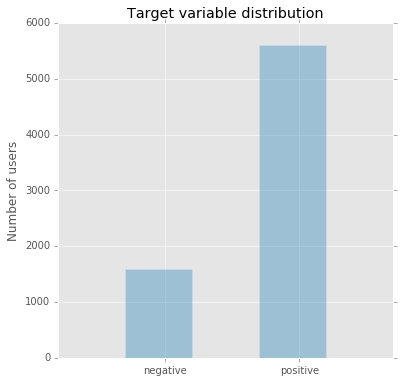

In [353]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cls"], bins=[0,1,2])

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ["negative", "positive"])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [3]:
CONSUMER_KEY = "ugobTj1J8YbCQoyNrDIucjOPX"
CONSUMER_SECRET = "eWBVA7VJfKYywSbAqe9tQJw50dHQvyLJCacFBoIs2dd2CkNTgY"

ACCESS_TOKEN_KEY = "781167349399490562-WLDzou6ho6w8yVLTKbrEPT0bdq0wSfg"
ACCESS_TOKEN_SECRET = "vrTd7102GIFrUAmNVHKJNn8wsqhGND2cTaaeKVjwsq8jO"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)
#for n in range(0, len(query["ids"]), 100):
#	ids = query["ids"][n:n+100]
#
#	#-----------------------------------------------------------------------
#	# create a subquery, looking up information about these users
#	# twitter API docs: https://dev.twitter.com/docs/api/1/get/users/lookup
#	#-----------------------------------------------------------------------
#twitter.get_users(["783212"])
#api.UsersLookup(map(str, [x for x in xrange(100, 200)]))
#subquery = api.users.lookup(user_id = "783214")

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничено 30тыс в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [5]:
class LimitException(Exception):pass
class HourLimitException(LimitException): 
    def __str__(self):
        return "User exceed maximum number of requests for hour"
class DayLimitException(LimitException):
    def __str__(self):
        return "User exceed maximum number of requests for day"

GEO_USER_NAME = "greenangel7"
coordinates_location_hash = "coordinates_location.json"
    
def get_coordinates_by_location(location, hash_file_name = coordinates_location_hash, limitToWrite = 100):
    if (not hasattr(get_coordinates_by_location, "hash_data")) or (hash_file_name != get_coordinates_by_location.hash_data_file_name):
        get_coordinates_by_location.hash_data = {}
        get_coordinates_by_location.hash_data_file_name = hash_file_name
        get_coordinates_by_location.newData = {}
        try:
            with open(hash_file_name, "r") as hash_file:
                for line in hash_file:
                    try:
                        get_coordinates_by_location.hash_data.update(json.loads(line))
                    except:
                        continue
        except:
            pass

    if location in get_coordinates_by_location.hash_data: 
        sys.stdout.write("Reading data from hash\n")
        return get_coordinates_by_location.hash_data[location]
    else:
        r = requests.get("http://api.geonames.org/search", 
                         params = 
                         {'q' : unicode(location),
                          'maxRows' : 1,
                          "username" : GEO_USER_NAME,
                         "type" : "json"})
        _answer = r.json()
        if 'totalResultsCount' in _answer and _answer['totalResultsCount'] != 0:
            sys.stdout.write(u"Processing data for {}\n".format(location))
            _answer = _answer[u'geonames'][0]
            answer = ( float(_answer['lng'] if 'lng' in _answer else None),
                       float(_answer['lat'] if 'lat' in _answer else None),
                      _answer['countryName'] if 'countryName' in _answer else None) # also I'm happy for people leaving on Earth
        else: # according to their data some users live in DC / Marvel. I wish they would
            if u'status' in _answer and u'message' in _answer[u'status']:
                if u'the hourly limit of 2000 credits for' in _answer[u'status'][u'message']:
                    raise HourLimitException()
                elif u'the daily limit of 30000 credits for':
                    raise DayLimitException()
                    
            sys.stderr.write(u"Can't find data for location {}\n".format(location))
            answer = (None, None, None)
            
        get_coordinates_by_location.newData[location] = answer
        get_coordinates_by_location.hash_data[location] = answer
        if (len(get_coordinates_by_location.newData) >= limitToWrite):
            with open(get_coordinates_by_location.hash_data_file_name , 'a') as hash_file:
                sys.stdout.write(u"Saving hash to local store - {}\n".format(get_coordinates_by_location.hash_data_file_name))
                hash_file.write(json.dumps(get_coordinates_by_location.newData, tmp_file) + "\n")
                get_coordinates_by_location.newData = {}
                
        return answer

p = get_coordinates_by_location("Long Island, New York")
print p

Reading data from hash
[-73.91327, 40.75766, u'United States']


In [281]:
p = get_coordinates_by_location("USA, New York")
print get_coordinates_by_location.hash_data

Processing data for USA, New York
{'USA, New York': (-74.00597, 40.71427, u'United States'), 'Long Island, New York': (-73.91327, 40.75766, u'United States')}


Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [13]:


def chunks(items, n): # split iterator into iterators
    items = iter(items)
    for first in items:
        chunk = chain((first,), islice(items, n-1))
        yield chunk
        deque(chunk, 0)


ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records = []
tmp_file_name = 'tmp_user_records'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name, 'r') as f:
        for line in f:
            try:
                user_records.append(json.loads(line))
            except:
                continue

processed_users = set()
for r in user_records:
    processed_users.add(r['uid'])

    


            
def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None  and user.location.strip() != "":
        record["location"] = user.location
        record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
    
    return record

def safeUsersLookup(user_group):
    try:
        return api.UsersLookup(user_group)
    except:
        sys.stderr.write("No additional info for current group of users\n") # for some users twitter dont send any info 
        return list()

def get_user_records(df, processed_users):
    all_users_records = list()
    for users_records_iter in (safeUsersLookup(user_group) for user_group in chunks(\
        ifilter(lambda x: x not in processed_users, df["uid"]), 100)):
        users_records = []
        for user in users_records_iter:
            record = None
            try:
                record = twitter_user_to_dataframe_record(user)
            except HourLimitException:
                sys.stderr.write("Hour limit has been exceeded, app is waiting now\n")
                time.sleep(4200) # more than one hour
                record = twitter_user_to_dataframe_record(user)
            users_records.append(record)
            
        with open(tmp_file_name, 'a') as tmp_file:
            for user in users_records:
                tmp_file.write(json.dumps(user, tmp_file) + "\n")
        all_users_records.extend(users_records)
        
        
    return all_users_records


user_records.extend(get_user_records(df_users, processed_users))


print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"

No additional info for current group of users
No additional info for current group of users
No additional info for current group of users
No additional info for current group of users
No additional info for current group of users
No additional info for current group of users


Creating data frame from loaded data
Merging data frame with the training set
Finished building data frame


## Exploratory Data Analysis

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://stroykova.github.io/sphera/l1_1.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (1 балл).

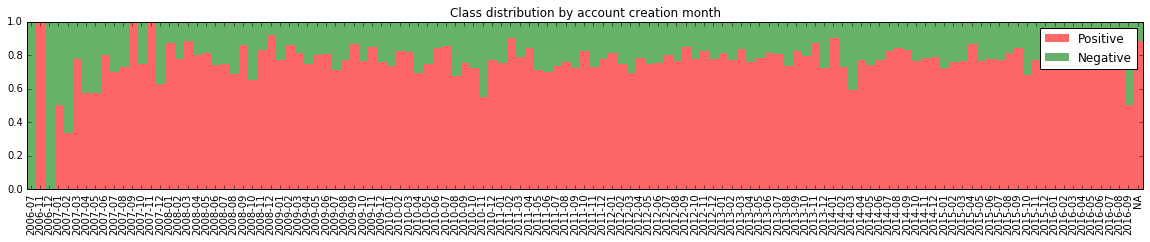

In [14]:
def count_users(grouped):
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
    """
    dts = []
    count_pos, count_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
    for index, (name, group) in enumerate(grouped):
        dts.append(name)
        count_pos[index] = sum(group['cls'] == 1)
        count_neg[index] = sum(group['cls'] == 0)
        
    # your code here 
    return count_pos, count_neg, dts


grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))




count_pos, count_neg, dts = count_users(grouped)
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()


Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://stroykova.github.io/sphera/l1_2.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (2 балла).

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


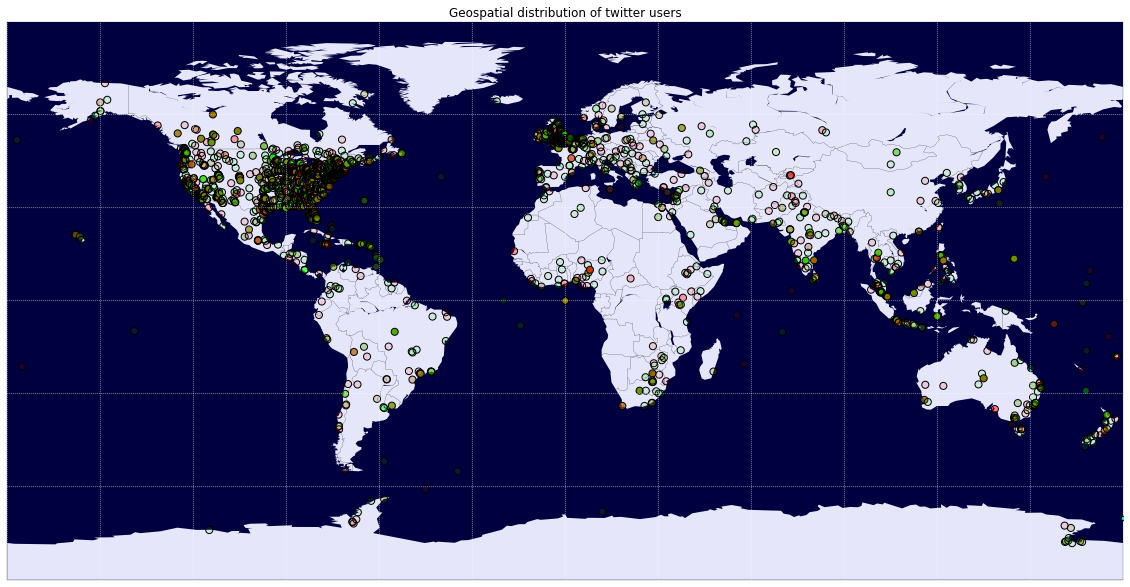

In [10]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
#m.fillcontinents(color='lightgray',zorder=0)
m.fillcontinents(color='lavender', lake_color='#000040', zorder = 0)
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)


def count_users_atCoord(grouped):
    coord_pos, coord_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
    coord_lat, coord_lon = np.zeros(len(grouped)), np.zeros(len(grouped))
    for index, (name, group) in enumerate(grouped):
        coord_pos[index] = sum(group['cls'] == 1)
        coord_neg[index] = len(group) - coord_pos[index]
        coord_lat[index] = name[0]
        coord_lon[index] = name[1]
        
    return coord_pos, coord_neg, coord_lat, coord_lon
#or you can pass an R , G , B tuple, where each of R , G , B are in the range [0,1
def determine_color_for_point(coord_pos, coord_neg):#, pos_color = (1, 0, 0),
                             #neg_color = (0, 1, 0)):
    color_r = np.zeros(len(coord_pos))
    color_g = np.zeros(len(coord_pos))
    color_b = np.zeros(len(coord_pos))
    count_sum = coord_pos + coord_neg
    color_alpha = count_sum / count_sum.mean() / 3
    color_alpha[color_alpha > 1] = 1
    color_r = coord_pos / count_sum
    color_g = coord_neg / count_sum
    return color_r, color_g, color_b, color_alpha
    

from itertools import izip
def plot_points_on_map(df_full):
    """
    Plot points on the map. Be creative.
    """
    pos_users = df_full[df_full['cls'] == 1]
    neg_users = df_full[df_full['cls'] == 0]
    
    #m.plot(pos_users['lat'], pos_users['lon'], 'ro', alpha = 0.44)
    #m.plot(neg_users['lat'], neg_users['lon'], 'go', alpha = 0.44)
    coord_pos, coord_neg, coord_lat, coord_lon =  count_users_atCoord(df_full.groupby([u'lat', u'lon']))
    color_r, color_g, color_b, color_alpha = determine_color_for_point(coord_pos, coord_neg)
    
    color = list([r,g,b, alpha] for r,g,b, alpha in izip(color_r, color_g, color_b, color_alpha))
    
    m.scatter(coord_lat, coord_lon, c = color, s = 50)
    
    return



plot_points_on_map(df_full)
m.scatter(180, -70, c = (0,1,1))
pl.title("Geospatial distribution of twitter users")
pl.legend()
pl.show()

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой (2 балла).


В поле ниже необходимо словами описать, как было улучшено изображение (описание необходимо для корректной проверки задания).

На изображении сделаны следующие улучшения:
* для каждой координаты из таблицы с помощью count_users_atCoord считается количество пользователей каждого класса в этом месте
* далее на основании этих данных с помощью  determine_color_for_point каждой координате задается промежуточный цвет (через отношение числа одних пользователей к числу другим), а также "вес точки", т.е ее прозрачность, 1 - для точек, в которых жителей больше в 3, чем в среднем (можно менять, мне кажется, что 3- оптимально)

#### Опредилим пользователи какого класса популярнее, а именно пользователи какого класса имеют больше фолловеров. 

Для этого
    1. Посчитайте дескриптивные статистики для признака followers_count -- min, max, mean и median 
    2. Постройте гистограммы для пользователей двух классов.
[подсказка](http://stroykova.github.io/sphera/l1_3.png) 
    3. На основе полученных данных ответьте на вопросы 
        1. Почему mean и median имеют разные значения?
        2. Пользователи какого класса популярнее? Аргументируйте ответ.
Подсказка: так как пользователей позитивного класса в 3.5 раза больше, чем негативного прежде чем приступать к анализу необходимо случайным образом выбрать по N(N>=500) пользователей негативного и позитивного классов. (1 балл)

Negative class users folowers params:
max = 490455.0
min = 0.0
median = 423.0
mean = 3697.66
Positive class users folowers params:
max = 1319648.0
min = 3.0
median = 398.5
mean = 4631.81


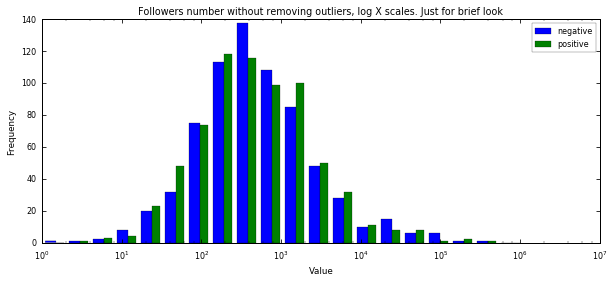

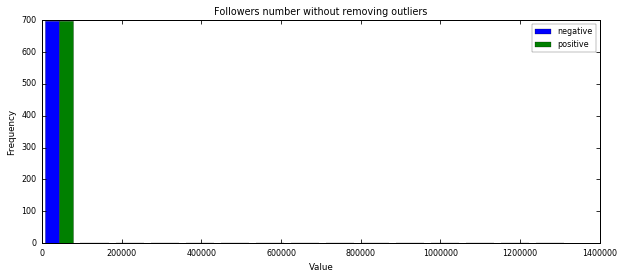

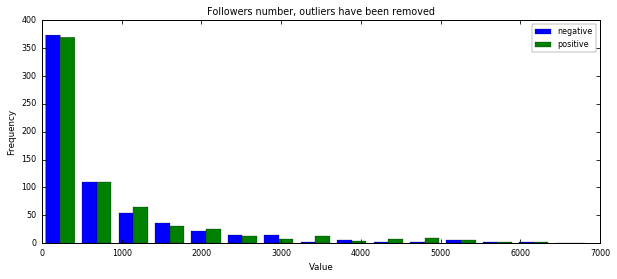

In [11]:
sample_number = 700
users_wth_neg_class = df_full[df_full["cls"]==0].dropna().sample(sample_number)
users_wth_pos_class = df_full[df_full["cls"]==1].dropna().sample(sample_number)
from itertools import takewhile


def turkey_remove(vector, k = 5): # remove outliers, k = 7 just to show some outliers, in normal k = 3 or k = 1.5
    upper_quartile = np.percentile(vector, 75)
    lower_quartile = np.percentile(vector, 25)
    low = upper_quartile - k * (upper_quartile - lower_quartile)
    high = upper_quartile + k * (upper_quartile - lower_quartile)
    return vector[vector < high]

def descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class):
    followers_neg = users_wth_neg_class[u'followers_count']
    followers_pos = users_wth_pos_class[u'followers_count']
    neg_class_params = {'mean' : followers_neg.mean(skipna = True),
                                   'median' : followers_neg.median(skipna = True),
                                   'min' : followers_neg.min(skipna = True),
                                   'max' : followers_neg.max(skipna = True)}
    pos_class_params = {'mean' : followers_pos.mean(skipna = True),
                                   'median' : followers_pos.median(skipna = True),
                                   'min' : followers_pos.min(skipna = True),
                                   'max' : followers_pos.max(skipna = True)}
        #Calculate min max and median. Plot histogram
        #Your code here
    sys.stdout.write("Negative class users folowers params:\n" + 
                     "".join( ("{0} = {1}\n".format(key, value) for key, value in neg_class_params.items())))
    sys.stdout.write("Positive class users folowers params:\n" +
                    "".join("{0} = {1}\n".format(key, value) for key, value in pos_class_params.items()))
    
    #have to remove outliers
    with plt.style.context(('seaborn-paper')):
        pl.figure(figsize=(10,4))
        
        
        n, _, patches = pl.hist([followers_neg, followers_pos], label = ["negative", "positive"],
                               bins = [2 ** x for x in 
                                    xrange(0,int(ceil(log2(max(neg_class_params['max'],
                                                         pos_class_params['max'])))))])
        pl.xlabel('Value')
        pl.ylabel('Frequency')
        pl.xscale("log")
        pl.title('Followers number without removing outliers, log X scales. Just for brief look')
        pl.legend()
        pl.show()
    
    
    with plt.style.context(('seaborn-paper')):
        pl.figure(figsize=(10,4))
        
        
        n, _, patches = pl.hist([followers_neg, followers_pos], label = ["negative", "positive"],
                                bins = 15)
        pl.xlabel('Value')
        pl.ylabel('Frequency')
        pl.title('Followers number without removing outliers')
        pl.legend()
        pl.show()
        

    followers_neg = turkey_remove(followers_neg).dropna()
    followers_pos = turkey_remove(followers_pos).dropna()
    # Plot the distribution
    with plt.style.context(('seaborn-paper')):
        pl.figure(figsize=(10,4))
        
        
        n, _, patches = pl.hist([followers_neg, followers_pos], label = ["negative", "positive"],
                                bins = [x for x in xrange(0, int(max(followers_neg.max(), followers_pos.max()) ),
                                                         int(max(followers_neg.max(), followers_pos.max()) ) / 15)])
        pl.xlabel('Value')
        pl.ylabel('Frequency')
        pl.title('Followers number, outliers have been removed')
        pl.legend()
        pl.show()
    return

descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class)

Медиана и среднее имеют сильно отличающиеся значения, т.к на среднее значение оказывают бОльшее влияние очень большие величины, которых немного и статистической ценности в них почти нет. В то время как медиана более устойчива к подобным выбросам
На первый взгляд распределения похожи. 



Смотрим на полученный data frame и сохраняем его в .csv файл.

4721.25


In [330]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,uid,cls,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,202388889,1,Kim Salter,mustangkim11,Author- Artist-Marvel-Cars-Books-Music,False,"Gulfport, FL",-82.70343,27.74836,United States,2010-10,1051,1962,9481,21323,27
1,1392518336,0,Tomboy Tarts,TomboyTarts,Celebrating the classic tomboy spirit with a b...,False,Singapore/Malaysia,103.52690,1.54860,Malaysia,2013-04,1196,836,19291,7183,110
2,361208576,1,THE MANC GEEK,BigA85GL,"Mancunian geek, blogger/writer/reviewer. Consu...",False,"Manchester, UK",-2.23743,53.48095,United Kingdom,2011-08,633,577,7851,1141,28
3,1535215357,1,L,laurynjiles,I'd rather be in Paris.,False,Marvel. DC.,NaN,NaN,None,2013-06,2369,2436,187956,88087,68
4,4396196375,1,#1stEdifyToUplift,EdifyToUplift,Awareness.Advocacy.Ascend🎈• Building awarenes...,False,God is my refuge; gem❤️,NaN,NaN,None,2015-12,1253,970,36809,27012,75
